# Challenge: TelecomX AluraLatam: Análisis de Evasión de Clientes (Telecom Churn)

Este proyecto recorre el ciclo completo de Data Science, desde la ingesta de datos crudos hasta la modelización predictiva avanzada.

## 🛠 Tech Stack Utilizado
* **Lenguaje:** Python 3.x
* **ETL & Procesamiento:**
    * `Pandas`: Manipulación de datos y desanidado de JSON.
    * `NumPy`: Cálculos numéricos eficientes.
    * `JSON`: Lectura de formatos crudos.
* **Visualización de Datos (EDA):**
    * `Matplotlib`: Gráficos base.
    * `Seaborn`: Visualizaciones estadísticas avanzadas.
* **Machine Learning (IA):**
    * `Scikit-Learn`: Entrenamiento de modelos (Random Forest, Gradient Boosting).
    * `GridSearchCV`: Optimización de hiperparámetros.
* **Ingeniería de Datos:**
    * `SQLite`: Simulación de carga a Base de Datos SQL.


In [11]:
# 1. Importación de librerías
import pandas as pd
import json
import numpy as np

# Configuración opcional para ver todas las columnas
pd.set_option('display.max_columns', None)

In [12]:
# 2. Extracción de datos desde el archivo JSON
try:
    # Cargar el archivo JSON crudo
    with open('TelecomX_Data.json', 'r') as file:
        data_raw = json.load(file)

    # Normalizar: Convierte el JSON anidado en una tabla plana de Pandas
    df_telecom = pd.json_normalize(data_raw)

    print("¡Datos cargados exitosamente!")

except FileNotFoundError:
    print("El archivo no se encuentra. Asegúrate de subir 'TelecomX_Data.json' al entorno.")

¡Datos cargados exitosamente!


In [13]:
# 3. Vista preliminar de los datos
print(f"Dimensiones del dataset: {df_telecom.shape}") # (filas, columnas)

# Mostrar las primeras 5 filas para verificar el aplanamiento
display(df_telecom.head())

# Verificar tipos de datos y nulos
df_telecom.info()

Dimensiones del dataset: (7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,internet.OnlineSecurity,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-null   object 
 13  internet.TechSupport       7267 non-null   objec

In [14]:
# FASE DE TRANSFORMACIÓN

# 1. Convertir Charges.Total a numérico
df_telecom['account.Charges.Total'] = pd.to_numeric(df_telecom['account.Charges.Total'], errors='coerce')

# 2. Manejo de valores nulos generados
print(f"Valores nulos en Total Charges: {df_telecom['account.Charges.Total'].isnull().sum()}")

# Llenamos esos nulos con 0
df_telecom['account.Charges.Total'] = df_telecom['account.Charges.Total'].fillna(0)

# 3. Convertir SeniorCitizen a categórico
# En el JSON viene como 0 o 1.
df_telecom['customer.SeniorCitizen'] = df_telecom['customer.SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# 4. Verificar que los tipos de datos ahora sean correctos
print("\nTipos de datos corregidos:")
print(df_telecom[['account.Charges.Total', 'account.Charges.Monthly', 'customer.tenure']].dtypes)

Valores nulos en Total Charges: 11

Tipos de datos corregidos:
account.Charges.Total      float64
account.Charges.Monthly    float64
customer.tenure              int64
dtype: object


Conteo de Churn post-limpieza:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


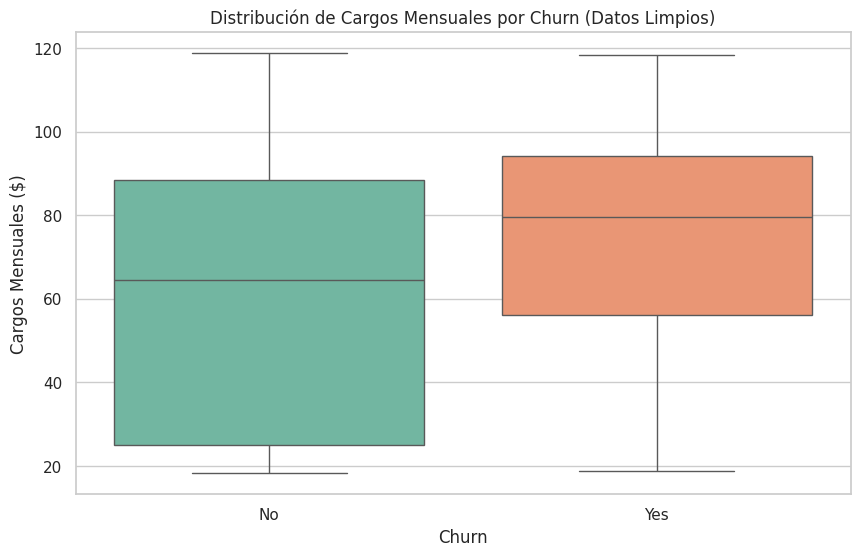


Promedio de pago mensual real:
Churn
No     61.265124
Yes    74.441332
Name: account.Charges.Monthly, dtype: float64


In [15]:
# LIMPIEZA FINAL DE LA VARIABLE OBJETIVO CHURN

# 1. Eliminar filas donde Churn está vacío
df_telecom = df_telecom[df_telecom['Churn'] != '']

# Verificamos que ya no existan esos 224 fantasmas
print("Conteo de Churn post-limpieza:")
print(df_telecom['Churn'].value_counts())

import matplotlib.pyplot as plt
import seaborn as sns

# Gráfico de Caja
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='Churn',
    y='account.Charges.Monthly',
    hue='Churn',
    data=df_telecom,
    palette="Set2",
    legend=False
)
plt.title('Distribución de Cargos Mensuales por Churn (Datos Limpios)')
plt.ylabel('Cargos Mensuales ($)')
plt.show()

# Estadísticas finales limpias
print("\nPromedio de pago mensual real:")
print(df_telecom.groupby('Churn')['account.Charges.Monthly'].mean())

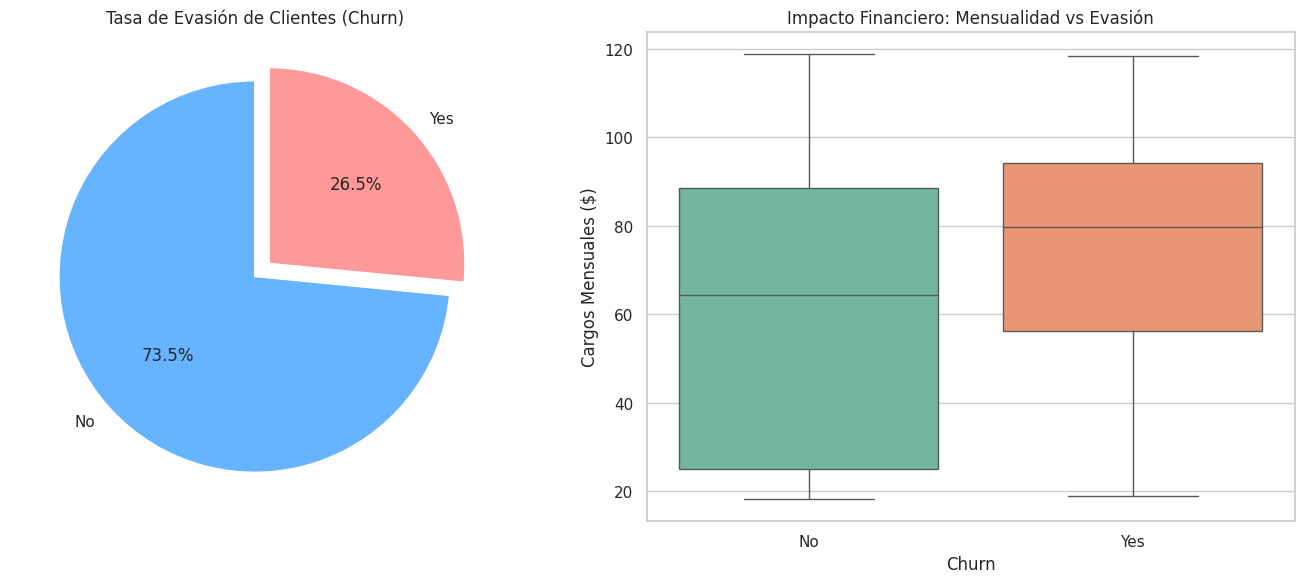

¡Análisis visual generado exitosamente!


In [17]:
# VISUALIZACIÓN FINAL PROFESIONAL
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración estética
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# GRÁFICO 1: Proporción de Fuga
churn_counts = df_telecom['Churn'].value_counts()
axes[0].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%',
            colors=['#66b3ff','#ff9999'], startangle=90, explode=(0, 0.1))
axes[0].set_title('Tasa de Evasión de Clientes (Churn)')

# GRÁFICO 2: Distribución de Pagos
sns.boxplot(
    x='Churn',
    y='account.Charges.Monthly',
    hue='Churn',
    data=df_telecom,
    palette="Set2",
    legend=False,
    ax=axes[1]
)
axes[1].set_title('Impacto Financiero: Mensualidad vs Evasión')
axes[1].set_ylabel('Cargos Mensuales ($)')

plt.tight_layout()
plt.show()

print("¡Análisis visual generado exitosamente!")

In [18]:
# CARGA (LOAD): EXPORTAR DATOS
df_telecom.to_csv('TelecomX_Clean_Data.csv', index=False)

print("¡Archivo 'TelecomX_Clean_Data.csv' guardado exitosamente!")
print("Tu proceso de ETL ha finalizado.")

¡Archivo 'TelecomX_Clean_Data.csv' guardado exitosamente!
Tu proceso de ETL ha finalizado.


In [19]:
# CARGA AVANZADA
import sqlite3
from datetime import datetime

# 1. CARGA A ARCHIVO CON VERSIONADO
fecha_hoy = datetime.now().strftime('%Y%m%d')
nombre_archivo = f'TelecomX_Clean_{fecha_hoy}.csv'

df_telecom.to_csv(nombre_archivo, index=False)
print(f"✅ Archivo CSV generado: {nombre_archivo}")

# 2. CARGA A BASE DE DATOS SQL
conexion = sqlite3.connect('telecom_churn.db')

# Escribimos el DataFrame directamente en una tabla SQL
df_telecom.to_sql(name='clientes_procesados', con=conexion, if_exists='replace', index=False)
print("✅ Datos cargados exitosamente en la Base de Datos SQL (SQLite)")

# 3. VERIFICACIÓN: CONSULTA SQL DE PRUEBA
query_prueba = """
SELECT
    Churn,
    COUNT(*) as Cantidad_Clientes,
    ROUND(AVG("account.Charges.Monthly"), 2) as Pago_Promedio
FROM clientes_procesados
GROUP BY Churn
"""

print("\n--- Reporte generado vía SQL ---")
df_reporte_sql = pd.read_sql(query_prueba, conexion)
display(df_reporte_sql)

# Cerramos la conexión para liberar memoria
conexion.close()

✅ Archivo CSV generado: TelecomX_Clean_20251218.csv
✅ Datos cargados exitosamente en la Base de Datos SQL (SQLite)

--- Reporte generado vía SQL ---


,Churn,Cantidad_Clientes,Pago_Promedio
0,No,5174,61.27
1,Yes,1869,74.44


### Extra: Modelo de Entreno usando Machine Learning

Iniciando entrenamiento del modelo...

Modelo entrenado! Precisión del modelo: 79.49%
Esto significa que la IA acierta en ese porcentaje de los casos.



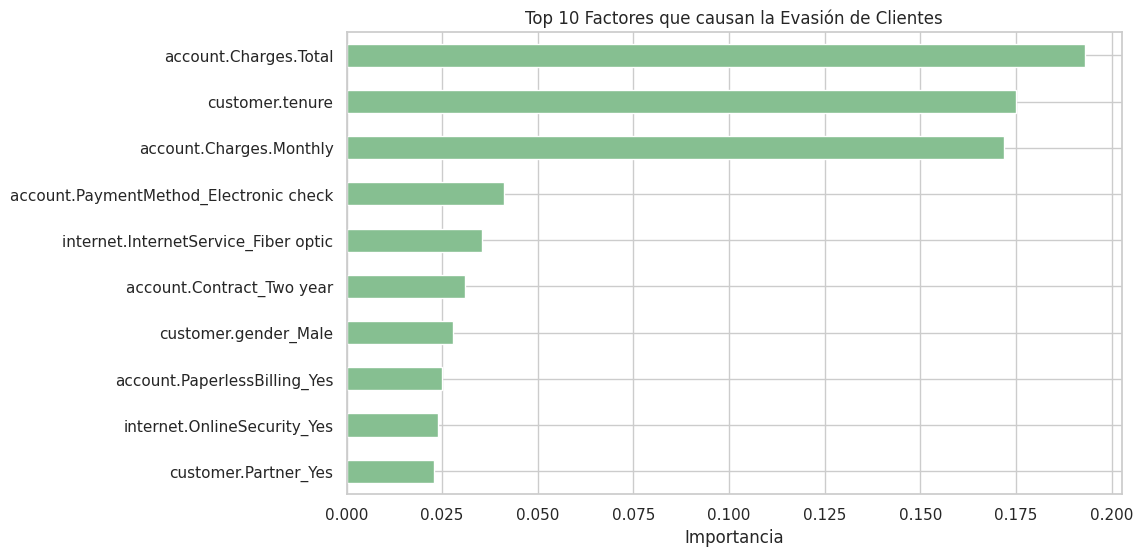

In [21]:
# --- BONUS TRACK: MACHINE LEARNING BÁSICO ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("Iniciando entrenamiento del modelo...")

# 1. PREPARACIÓN DE DATOS (Pre-processing)
df_ml = df_telecom.drop(columns=['customerID'])

# Convertimos la variable objetivo (Churn) a números: Yes=1, No=0
df_ml['Churn'] = df_ml['Churn'].map({'Yes': 1, 'No': 0})

# Convertimos todo el texto restante a números automáticamente (One-Hot Encoding)
df_ml = pd.get_dummies(df_ml, drop_first=True)

# 2. SEPARACIÓN DE DATOS
X = df_ml.drop(columns=['Churn'])
y = df_ml['Churn']

# Usamos el 80% para estudiar (train) y guardamos el 20% para el examen final
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. ENTRENAMIENTO
modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)

# 4. PREDICCIÓN Y EVALUACIÓN
predicciones = modelo.predict(X_test)
precision = accuracy_score(y_test, predicciones)

print(f"\nModelo entrenado! Precisión del modelo: {precision:.2%}")
print("Esto significa que la IA acierta en ese porcentaje de los casos.\n")

# 5. ¿QUÉ ES LO MÁS IMPORTANTE?
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
importancias.nlargest(10).plot(kind='barh', color='#86bf91')
plt.title('Top 10 Factores que causan la Evasión de Clientes')
plt.xlabel('Importancia')
plt.gca().invert_yaxis()
plt.show()

Entrenando Modelo Avanzado (Gradient Boosting)...
Precisión Modelo V1 (Random Forest): 79.49%
Precisión Modelo V2 (Gradient Boosting): 79.13%


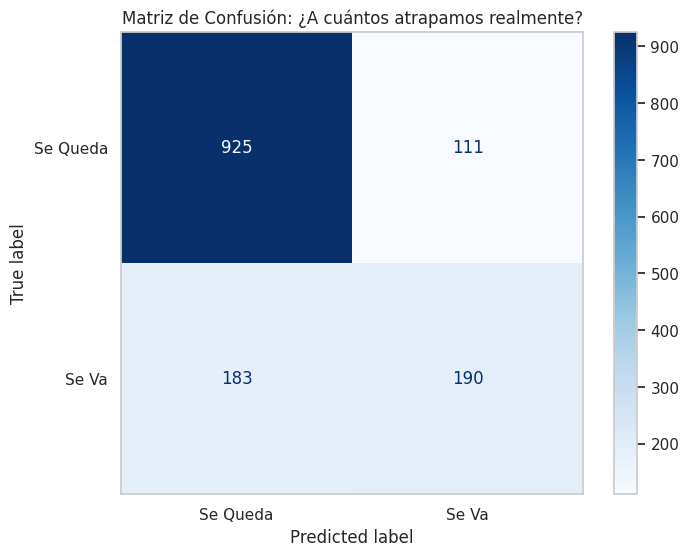


REPORTE DETALLADO (Fíjate en la fila '1' -> Recall):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.63      0.51      0.56       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [25]:
# MEJORA DEL MODELO PREDICTIVO
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Entrenando Modelo Avanzado (Gradient Boosting)...")

# 1. Configuración
modelo_v2 = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# 2. Entrenamiento
modelo_v2.fit(X_train, y_train)

# 3. Evaluación Comparativa
predicciones_v2 = modelo_v2.predict(X_test)
precision_v2 = accuracy_score(y_test, predicciones_v2)

print(f"Precisión Modelo V1 (Random Forest): {precision:.2%}")
print(f"Precisión Modelo V2 (Gradient Boosting): {precision_v2:.2%}")

# 4. Matriz de Confusión
cm = confusion_matrix(y_test, predicciones_v2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Se Queda', 'Se Va'])

# Visualizamos
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title('Matriz de Confusión: ¿A cuántos atrapamos realmente?')
plt.grid(False)
plt.show()

# Reporte detallado
print("\nREPORTE DETALLADO (Fíjate en la fila '1' -> Recall):")
print(classification_report(y_test, predicciones_v2))

In [26]:
# OPTIMIZACIÓN AUTOMÁTICA - GRID SEARCH
from sklearn.model_selection import GridSearchCV

print("Iniciando búsqueda intensiva del mejor modelo (Esto tomará unos segundos)...")

# 1. Definición modelos
parametros = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# 2. Configuramos el Entrenador Automático
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=parametros,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# 3. Entrenamiento
grid_search.fit(X_train, y_train)

# 4. Resultados
best_model = grid_search.best_estimator_
predicciones_optimas = best_model.predict(X_test)
precision_optima = accuracy_score(y_test, predicciones_optimas)

print(f"\n MEJOR CONFIGURACIÓN ENCONTRADA: {grid_search.best_params_}")
print(f" Precisión Final Optimizada: {precision_optima:.2%}")

# Comparativa final
print("\nComparativa de Modelos")
print(f"Modelo 1 (Básico): 79.49%")
print(f"Modelo 2 (Boosting): 79.13%")
print(f"Modelo 3 (Optimizado): {precision_optima:.2%}")

Iniciando búsqueda intensiva del mejor modelo (Esto tomará unos segundos)...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

 MEJOR CONFIGURACIÓN ENCONTRADA: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
 Precisión Final Optimizada: 80.48%

Comparativa de Modelos
Modelo 1 (Básico): 79.49%
Modelo 2 (Boosting): 79.13%
Modelo 3 (Optimizado): 80.48%


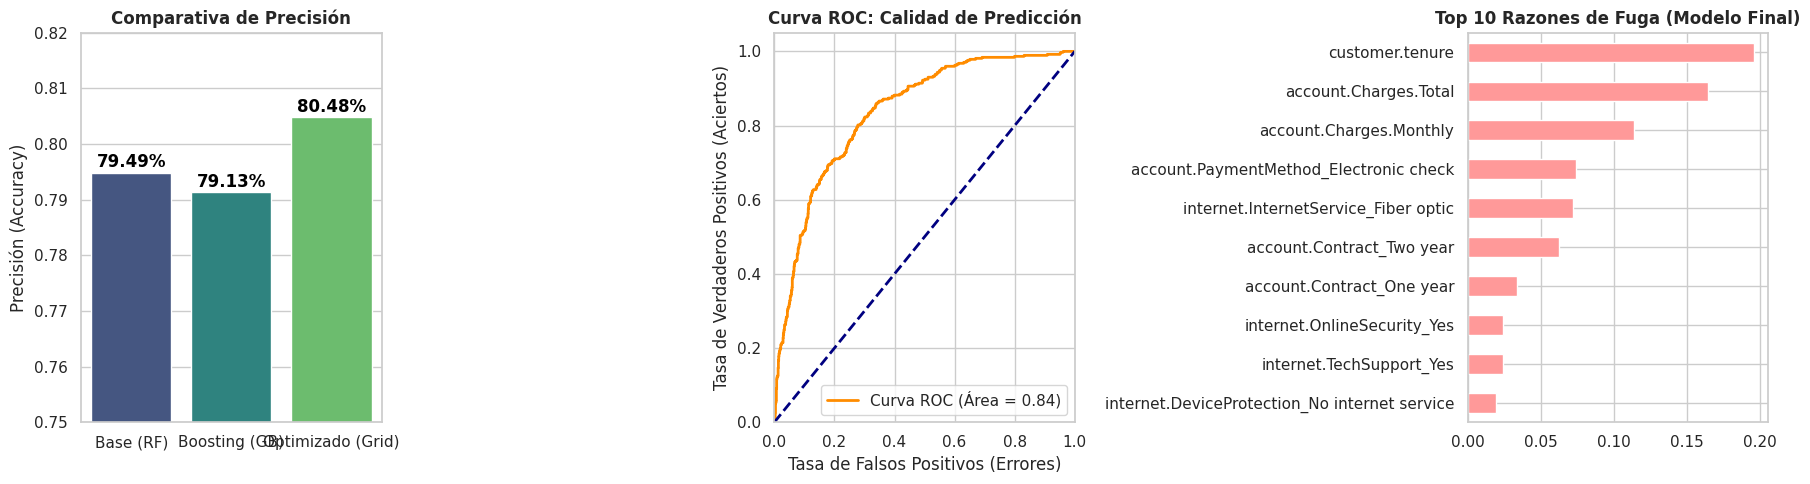

In [28]:
# DASHBOARD FINAL DE RESULTADOS
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc

sns.set_style("whitegrid")

# Configuración del lienzo
fig = plt.figure(figsize=(18, 5))

# GRÁFICO 1: COMPARATIVA DE PRECISIÓN
nombres_modelos = ['Base (RF)', 'Boosting (GB)', 'Optimizado (Grid)']
resultados = [precision, precision_v2, precision_optima]

ax1 = plt.subplot(1, 3, 1)
# Creo las barras
barras = sns.barplot(x=nombres_modelos, y=resultados, palette='viridis', ax=ax1, hue=nombres_modelos, legend=False)
ax1.set_ylim(0.75, 0.82) # Zoom vertical
ax1.set_title('Comparativa de Precisión', fontsize=12, fontweight='bold')
ax1.set_ylabel('Precisión (Accuracy)')

# Pongo el número encima de cada barra
for i, v in enumerate(resultados):
    ax1.text(i, v + 0.001, f"{v:.2%}", ha='center', fontweight='bold', color='black')

# GRÁFICO 2: CURVA ROC
ax2 = plt.subplot(1, 3, 2)

# Calculo la curva usando las probabilidades del MEJOR modelo
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Dibujamos
ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (Área = {roc_auc:.2f})')
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Tasa de Falsos Positivos (Errores)')
ax2.set_ylabel('Tasa de Verdaderos Positivos (Aciertos)')
ax2.set_title('Curva ROC: Calidad de Predicción', fontsize=12, fontweight='bold')
ax2.legend(loc="lower right")

# GRÁFICO 3: TOP FACTORES DEL MEJOR MODELO
ax3 = plt.subplot(1, 3, 3)
importancias_opt = pd.Series(best_model.feature_importances_, index=X.columns)
importancias_opt.nlargest(10).plot(kind='barh', color='#ff9999', ax=ax3)
ax3.set_title('Top 10 Razones de Fuga (Modelo Final)', fontsize=12, fontweight='bold')
ax3.invert_yaxis()

plt.tight_layout()
plt.show()